In [2]:
import pandas as pd

In [10]:
df=pd.read_csv('stock_price.csv')
df

,Date,Close,Open,High,Low,Volume,Change
0,01-08-2024,156.3,159.3,159.4,156.1,79.15M,-2.56%
1,31-07-2024,160.4,158.2,160.7,158.1,173.91M,1.07%
2,30-07-2024,158.7,158.8,159.2,158.0,138.14M,-0.63%
3,29-07-2024,159.7,158.7,160.2,158.4,126.28M,1.14%
4,26-07-2024,157.9,159.3,159.6,157.9,155.08M,-0.13%
...,...,...,...,...,...,...,...
9197,18-02-1987,191.2,186.3,191.2,186.3,795.09M,4.82%
9198,17-02-1987,182.4,176.5,184.3,175.5,881.51M,3.93%
9199,16-02-1987,175.5,166.7,175.5,165.7,360.51M,1.74%
9200,13-02-1987,172.5,176.5,176.5,172.5,422.38M,-5.43%


In [11]:
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

# Set 'Date' as the index for easier time-based slicing
df.set_index('Date', inplace=True)
df.head()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2024-08-01,156.3,159.3,159.4,156.1,79.15M,-2.56%
2024-07-31,160.4,158.2,160.7,158.1,173.91M,1.07%
2024-07-30,158.7,158.8,159.2,158.0,138.14M,-0.63%
2024-07-29,159.7,158.7,160.2,158.4,126.28M,1.14%
2024-07-26,157.9,159.3,159.6,157.9,155.08M,-0.13%


In [12]:
def clean_percentage(change):
    if isinstance(change, str):  # Check if the value is a string
        return float(change.replace('%', ''))
    return change  # Return the original value if it's already numeric or NaN

df['Change'] = df['Change'].apply(clean_percentage)

def convert_volume(volume):
    if isinstance(volume, str):  # Check if the value is a string
        volume = volume.strip()  # Remove leading/trailing spaces
        if 'B' in volume:
            return float(volume.replace('B', '')) * 1e9  # Convert billions
        elif 'M' in volume:
            return float(volume.replace('M', '')) * 1e6  # Convert millions
    elif isinstance(volume, (float, int)):
        return volume  # Return if it's already a numeric type
    return np.nan  # Return NaN for anything unexpected

# Apply the function to the Volume column
df['Volume'] = df['Volume'].apply(convert_volume)
df = df.iloc[::-1]
df.isnull().sum()


,0
Close,0
Open,0
High,0
Low,0
Volume,0
Change,0


In [13]:
df.head()


,Close,Open,High,Low,Volume,Change
Date,,,,,,
1987-02-12,182.4,182.4,182.4,182.4,1.280000e+09,16.25
1987-02-13,172.5,176.5,176.5,172.5,4.223800e+08,-5.43
1987-02-16,175.5,166.7,175.5,165.7,3.605100e+08,1.74
1987-02-17,182.4,176.5,184.3,175.5,8.815100e+08,3.93
1987-02-18,191.2,186.3,191.2,186.3,7.950900e+08,4.82


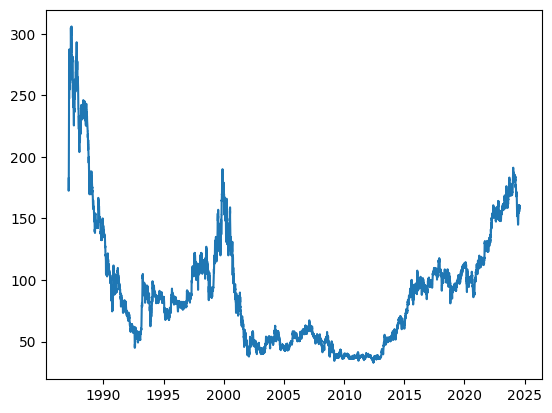

In [14]:
import matplotlib.pyplot as plt
plt.plot(df['Close'])


In [15]:
df1=df.reset_index()['Close']


In [16]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [17]:
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]


In [18]:
training_size,test_size

(5981, 3221)

In [20]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [21]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [22]:
print(X_test)


[[0.01795529 0.01978747 0.0190546  ... 0.0190546  0.02052034 0.02565042]
 [0.01978747 0.0190546  0.02198608 ... 0.02052034 0.02565042 0.02674973]
 [0.0190546  0.02198608 0.01978747 ... 0.02565042 0.02674973 0.02601686]
 ...
 [0.54122389 0.54122389 0.54635398 ... 0.45987541 0.45840967 0.4576768 ]
 [0.54122389 0.54635398 0.55368267 ... 0.45840967 0.4576768  0.46427263]
 [0.54635398 0.55368267 0.55881275 ... 0.4576768  0.46427263 0.46060828]]


In [23]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [24]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [25]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [26]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 100, 50)             │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 100, 50)             │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=10,batch_size=64,verbose=1)


Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 229ms/step - loss: 9.5273e-04 - val_loss: 2.8777e-04
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 38s 202ms/step - loss: 4.0753e-04 - val_loss: 3.7621e-04
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 207ms/step - loss: 3.8224e-04 - val_loss: 1.4270e-04
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 203ms/step - loss: 3.1318e-04 - val_loss: 1.4519e-04
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 208ms/step - loss: 2.8961e-04 - val_loss: 2.0295e-04
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 18s 199ms/step - loss: 3.0490e-04 - val_loss: 1.1906e-04
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 212ms/step - loss: 2.8302e-04 - val_loss: 1.5040e-04
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 18s 198ms/step - loss: 2.3266e-04 - val_loss: 1.0780e-04
Epoch 9/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 200ms/step - loss: 2.6160e-04 - val_loss: 2.2813e-04
Epoch 10/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 206ms/step - loss: 2.6130e-04 - val_loss: 9.9887e-05


In [29]:
import tensorflow as tf


In [30]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

184/184 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step


In [34]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

0.014005807766259685

In [35]:
math.sqrt(mean_squared_error(ytest,test_predict))


0.009994329998065822

In [37]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

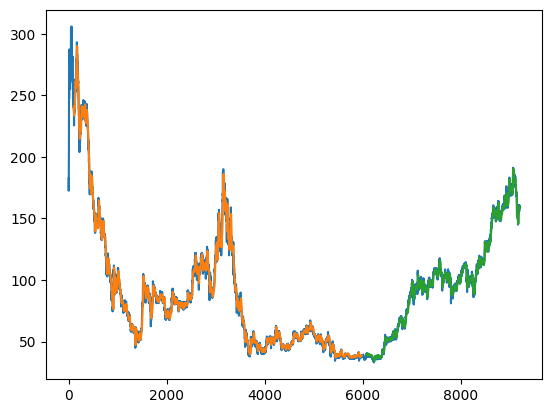

In [40]:
### Plotting
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [41]:
x_input=test_data[341:].reshape(1,-1)
x_input.shape

(1, 2880)

In [42]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [45]:
from numpy import array

lst_output = []
n_steps = 100
i = 0

while(i < 30):

    if(len(temp_input) > 100):
        # Slice the input to match n_steps (100 steps)
        x_input = np.array(temp_input[-100:])  # Take the last 100 elements
        print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, n_steps, 1)  # Reshape to (1, 100, 1)

        # Make a prediction
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))

        # Update temp_input with the predicted value
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]  # Keep only the last 100 elements

        lst_output.extend(yhat.tolist())
        i += 1

    else:
        # Initial prediction if temp_input is smaller than 100
        x_input = np.array(temp_input).reshape(1, n_steps, 1)
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])

        # Update temp_input with the predicted value
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

print(lst_output)

0 day input [0.43349212 0.42872847 0.43312569 0.42946134 0.42139978 0.42066691
 0.41590326 0.41004031 0.41223892 0.41260535 0.41407109 0.41773543
 0.42652986 0.43202638 0.43349212 0.43349212 0.43532429 0.45144742
 0.45144742 0.45987541 0.4565775  0.45034811 0.44448516 0.45254672
 0.45914254 0.46353976 0.46060828 0.45511176 0.46427263 0.46830341
 0.46170759 0.4650055  0.46793697 0.45987541 0.45840967 0.4576768
 0.46427263 0.46060828 0.46683767 0.45181385 0.46055037 0.45968902
 0.45887324 0.45813081 0.45746559 0.45686877 0.45632681 0.45582628
 0.45535612 0.45490834 0.45447788 0.45406169 0.45365861 0.45326772
 0.45288894 0.45252189 0.45216599 0.45182097 0.45148587 0.45115986
 0.45084214 0.45053148 0.45022714 0.44992828 0.44963399 0.44934338
 0.44905597 0.44877103 0.44848791 0.44820648 0.44792593 0.44764623
 0.44736683 0.44708768 0.44680843 0.44652924 0.44624951 0.44596946
 0.44568899 0.44540811 0.4451265  0.44484448 0.44456199 0.44427896
 0.44399554 0.4437117  0.44342741 0.44314292 0.4428

In [46]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

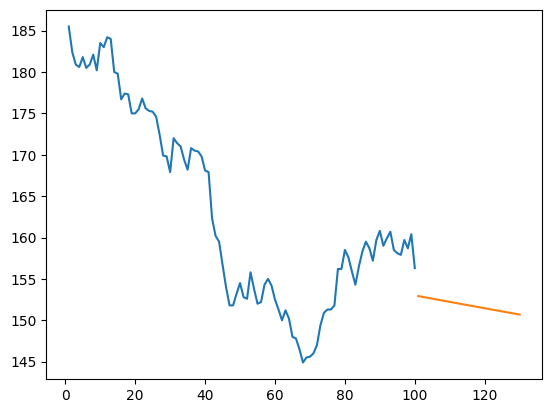

In [47]:
import matplotlib.pyplot as plt
plt.plot(day_new,scaler.inverse_transform(df1[9102:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

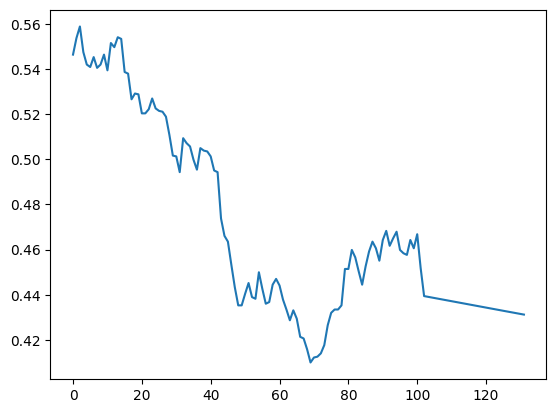

In [48]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[9100:])

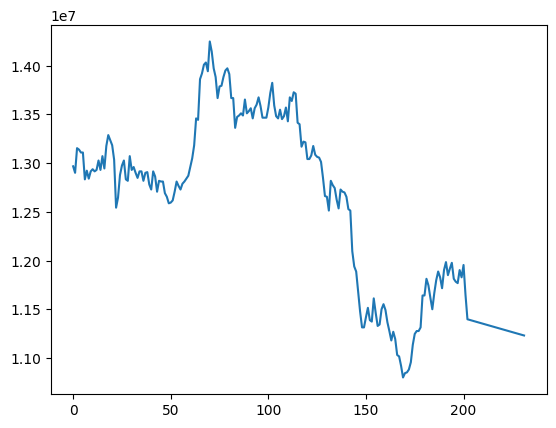

In [51]:
df3=scaler.inverse_transform(df3).tolist()
plt.plot(df3[9000:])
